In [1]:
import orbitize
from orbitize import driver
import matplotlib.pyplot as plt
import multiprocessing as mp
import warnings
warnings.filterwarnings("ignore")

In [3]:
# MCMC parameters
num_walkers = 50
num_threads = mp.cpu_count() # or a different number if you prefer

my_driver = orbitize.driver.Driver('AAS237_Ha-orbitizetab.csv', # path to data file
                                  'MCMC', # name of algorithm for orbit-fitting
                                  1, # number of secondary bodies in system
                                  2.25, # total system mass [M_sun]
                                  6.35606723729484, # total parallax of system [mas]
                                  mass_err=0.5, # mass error [M_sun]
                                  plx_err=0.04714455423, # parallax error [mas]
                                  mcmc_kwargs={'num_walkers': num_walkers, 'num_threads': num_threads})

In [9]:
# RUN MCMC
total_orbits = 10000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 1000 # steps to burn in per walker
thin = 1 # only save every 2nd step

my_driver.sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

Burn in complete
200/200 steps completed
Run complete


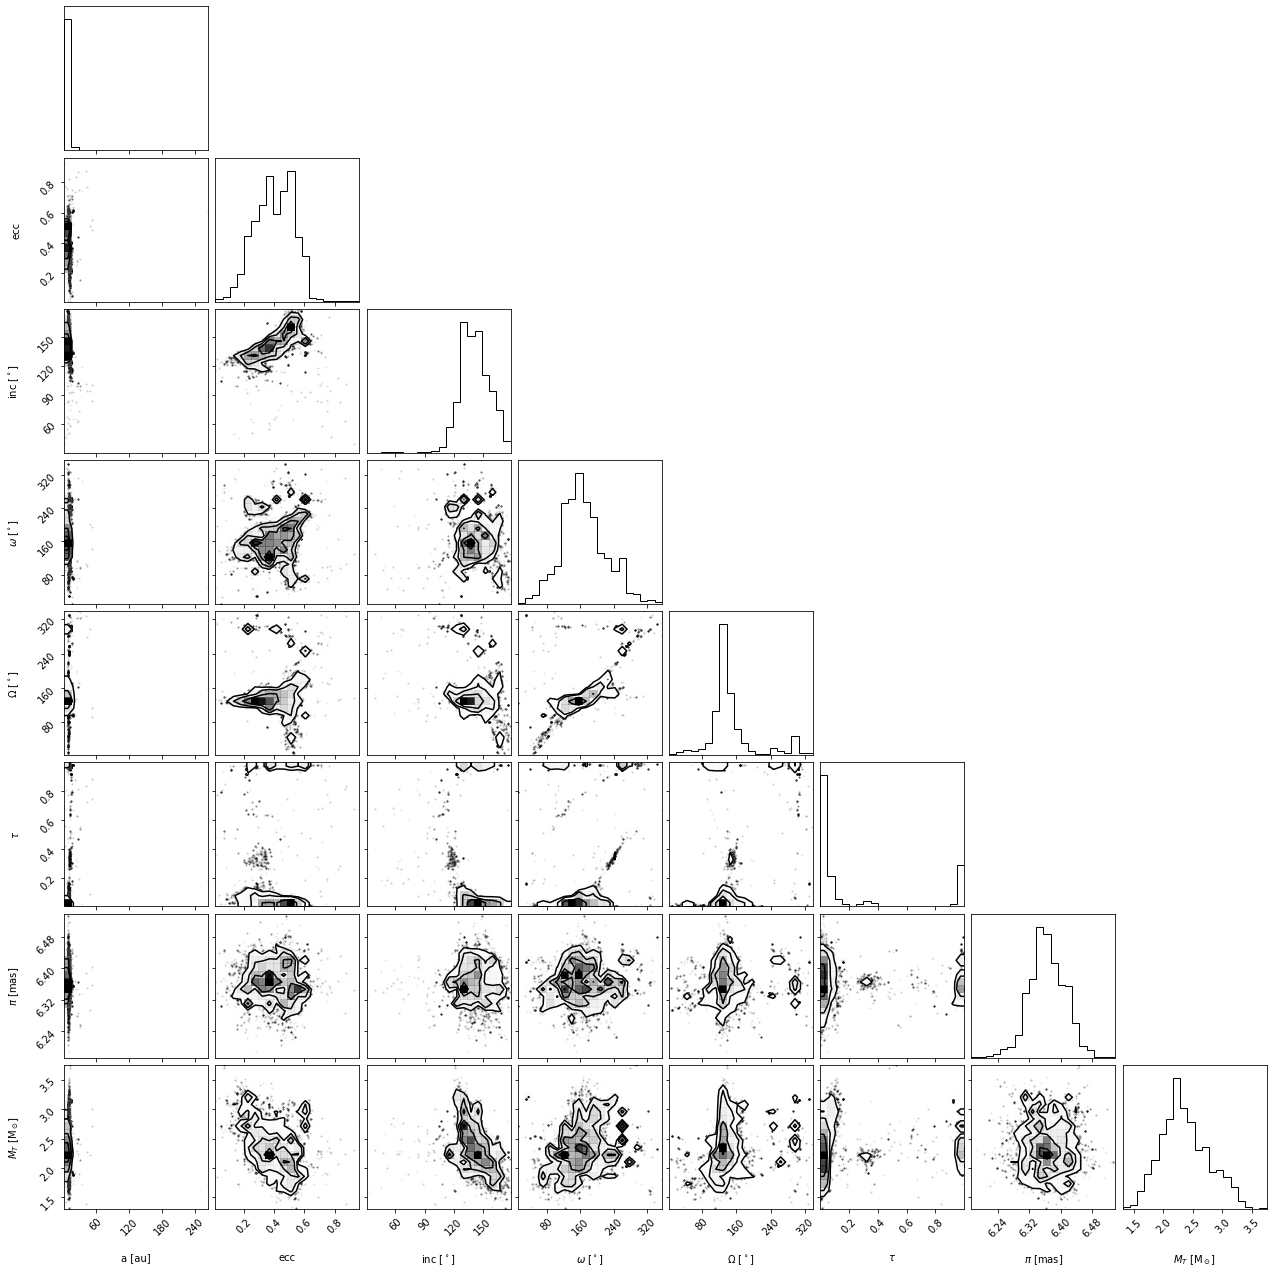

In [10]:
#MCMC PLOTS
corner_plot_fig = my_driver.sampler.results.plot_corner() # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('b2b3_corner_plot.png') # This is matplotlib.figure.Figure.savefig()

<Figure size 1008x432 with 0 Axes>

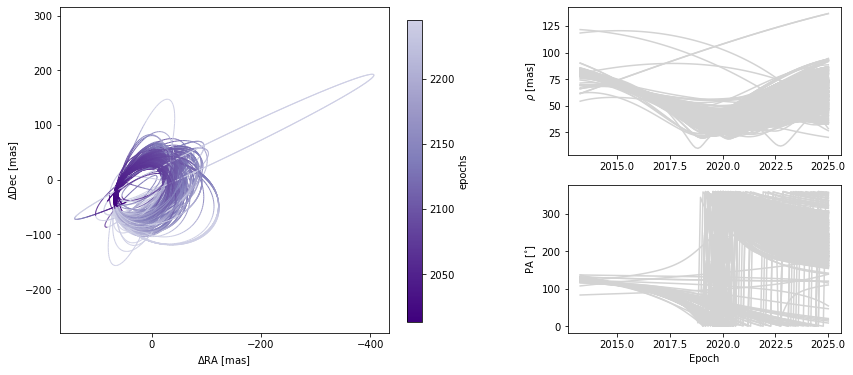

In [11]:
epochs = my_driver.system.data_table['epoch']
orbit_plot_fig = my_driver.sampler.results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 500, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0] # Minimum MJD for colorbar (here we choose first data epoch)
)
orbit_plot_fig.savefig('b2b3_orbit_plot.png') # This is matplotlib.figure.Figure.savefig()

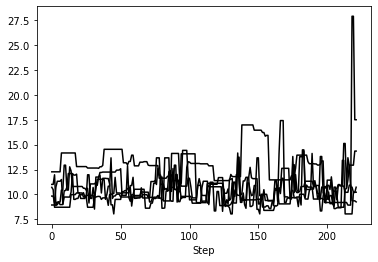

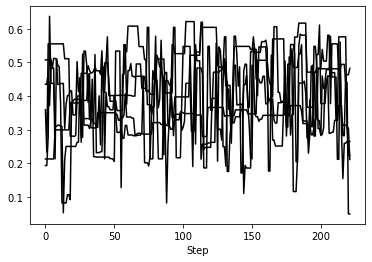

In [12]:
sma_chains, ecc_chains = my_driver.sampler.examine_chains(param_list=['sma1','ecc1'], n_walkers=5)

In [13]:
# save result as hdf5
hdf5_filename='my_posterior.hdf5'
import os
# To avoid weird behaviours, delete saved file if it already exists from a previous run of this notebook
if os.path.isfile(hdf5_filename):
    os.remove(hdf5_filename)
my_driver.sampler.results.save_results(hdf5_filename)

In [ ]:
# # save orbits result as csv
# import pandas as pd
# data = myResults.post
# df = pd.DataFrame(data, columns=myResults.labels)
# df.to_csv('test.csv')

In [3]:
# load in saved hdf5 result
hdf5_filename='my_posterior.hdf5'
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename) 

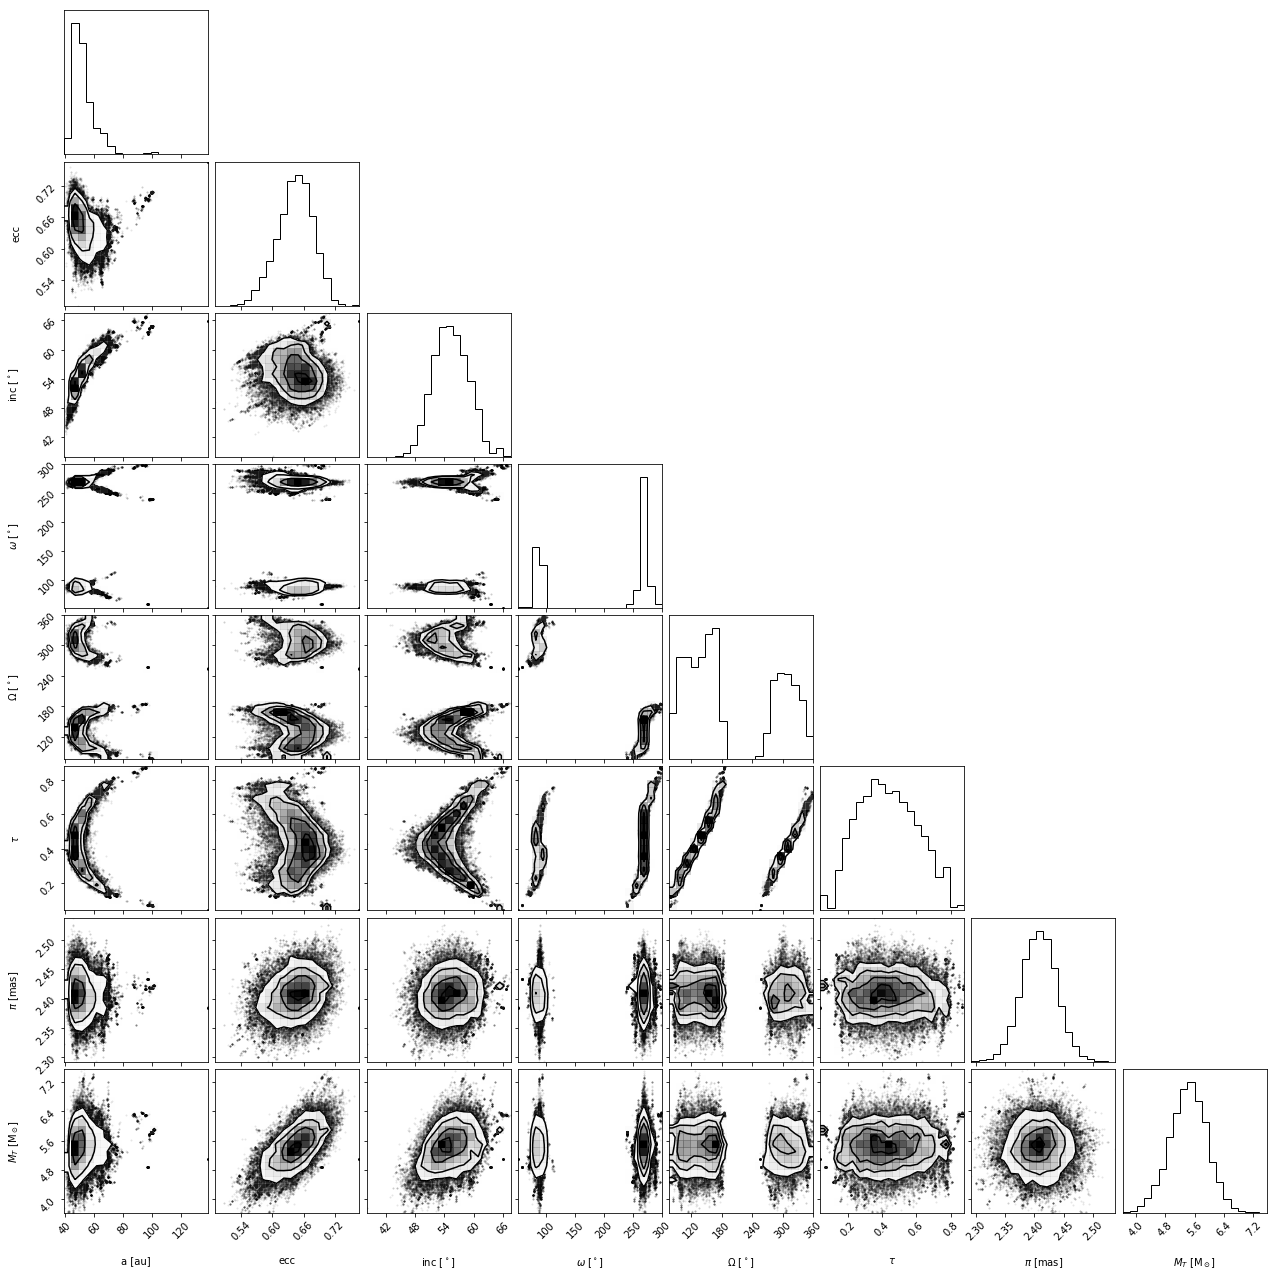

In [6]:
#MCMC PLOTS
corner_plot_fig = loaded_results.plot_corner() # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('b2b3_corner_plot.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

<Figure size 1008x432 with 0 Axes>

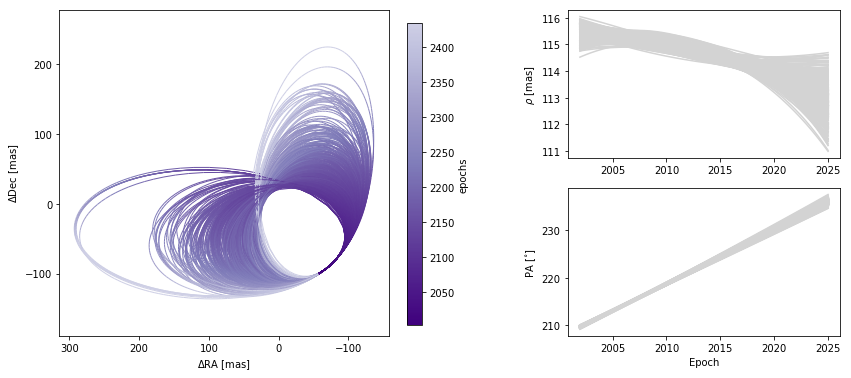

In [11]:
epochs = my_driver.system.data_table['epoch']

orbit_plot_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 500, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0] # Minimum MJD for colorbar (here we choose first data epoch)
)
orbit_plot_fig.savefig('b2b3_orbit_plot.png', dpi=300) # This is matplotlib.figure.Figure.savefig()